<a id="top"></a>

## Table of contents
Following CRISP-DM process 

#### [SECTION 1](#section1) | Business understanding : 

    Brief description
    Question 1
    Question 2
    Question 3

#### [SECTION 2](#section2) | Data understanding

#### [SECTION 3](#section3) | Data preparation

#### [SECTION 4](#section4) | Evaluation of the results
    
    Question 1        
        Analyze
        Visualize
        Brief explanation for visualization
    
    Question 2
        Analyze
        Visualize
        Brief explanation for visualization
        
    Question 3
        Analyze
        Visualize
        Brief explanation for visualization

#### Remark
- Data modeling was not conducted for this analysis. 
- Please note that another round of data preparation will be performed to fine tune the data whenever necessary before the analysis of each question.

---
<a id="section1"></a>
# SECTION 1 | Business understanding
This analysis is to expand understanding over the fast growing Airbnb business. For this purpose, Airbnb data were retrieved from Kaggle for two U.S. cities-Seattle and Boston, which includes information about Airbnb activities in 2016. 
 
### [Question 1](#question1) How well Airbnb business performed in 2016? 
Applying some straighforward hospitality performance evaluation metrics

### [Question 2](#question2) How much growth potential did Airbnb have?
Looking at number of new listings by year

### [Question 3](#question3) Which neighborhood has more expensive listings?
Using Python's GeoPandas libraries for geogrpahical mapping and visualization

---
<a id="section2"></a>
# SECTION 2 | Data understanding

<a id="package"></a>
## Importing packages

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
from zipfile import ZipFile

from datetime import datetime

In [2]:
# Matplotlib axis formatter
from matplotlib.axis import Axis   
import matplotlib.ticker as ticker 

In [3]:
# Geopandas package
import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes

<a id="dataset"></a>
## Reading Airbnb dataset

In [4]:
DATA_PATH = os.path.join(os.getcwd(), 'data')
FILE_PATH_SEATTLE = os.path.join(DATA_PATH, 'seattle.zip')
FILE_PATH_BOSTON = os.path.join(DATA_PATH, 'boston.zip')

In [5]:
def extract_df_from_airbnb_zipfile(PATH_ZIPFILE) :
    ''' 
    Extract csv files from a zipfile and return a list of dataframes
    
    INPUT  : file path to a zipfile to open
    OUTPUT : a dictionary that contains dataframes of files 
    extracted from the zip file
    '''

    zf = ZipFile(PATH_ZIPFILE) 
    dfs = {
        text_file.filename : pd.read_csv(zf.open(text_file.filename ))
        for text_file in zf.infolist() 
        if text_file.filename.endswith('.csv')
    }
    
    print('Printing a dictionary with filenames as keys')
    for filename in dfs.keys() :
        print(f'Filename (keys): {filename}')
    
    return dfs

### Seattle

In [6]:
dfs_seattle = extract_df_from_airbnb_zipfile(FILE_PATH_SEATTLE)

Printing a dictionary with filenames as keys
Filename (keys): calendar.csv
Filename (keys): listings.csv
Filename (keys): reviews.csv


In [7]:
listings_seattle = dfs_seattle['listings.csv']
reviews_seattle = dfs_seattle['reviews.csv']
calendar_seattle = dfs_seattle['calendar.csv']

### Boston

In [8]:
dfs_boston = extract_df_from_airbnb_zipfile(FILE_PATH_BOSTON)

Printing a dictionary with filenames as keys
Filename (keys): calendar.csv
Filename (keys): listings.csv
Filename (keys): reviews.csv


In [9]:
calendar_boston = dfs_boston['calendar.csv']
listings_boston = dfs_boston['listings.csv']
reviews_boston = dfs_boston['reviews.csv']

## Exploring the data
The respective Airbnb datasets are downloaded from : 

- Seattle : https://www.kaggle.com/airbnb/seattle
- Boston  : https://www.kaggle.com/airbnb/boston

### Content
- Listings, including full descriptions and average review score
- Review, including unique id for each reviewer and detailed comments
- Calendar, including listing id and the price and availability for that day

### Inspiration
- Can you describe the vibe of each Seattle neighborhood using listing descriptions?
- What are the busiest times of the year to visit Seattle? By how much do prices spike?
- Is there a general upward trend of both new Airbnb listings and total Airbnb visitors to Seattle?

Reference to the real use of the data: http://insideairbnb.com/seattle/

---
<a id="section3"></a>
# SECTION 3 | Data preparation

<a id="fuctions"></a>
## Defining helper functions
Collect all helper functions to use in this notebook.

In [10]:
# Helper function
def convert_str_to_datetime(df, date_feature) :
    ''' 
    Convert a series of date string to datetime object
    
    INPUT  : a dataframe and a column that contains date data
    OUTPUT : a series in datetime dtype 
    '''
    date_conversion = lambda x : datetime.strptime(x, "%Y-%m-%d")
    
    return df[date_feature].apply(date_conversion)
    

def break_date(df, date_feature) :
    '''
    Break down a datetime object into year, month, day
    and save the information in new columns of input dataframe
    
    INPUT  : a dataframe and a column that contains date data
    OUTPUT : a dataframe that adds 3 newly created date columns 
    to the original dataframe
    '''

    df_new = df.copy()
    
    df_new[date_feature] = convert_str_to_datetime(df_new, date_feature)

    df_new['year'] = df_new[date_feature].apply(lambda x : x.year)
    df_new['month'] = df_new[date_feature].apply(lambda x : x.month)
    df_new['day'] = df_new[date_feature].apply(lambda x : x.day)
    
    return df_new
    

In [11]:
def convert_price_float(series) :
    '''
    Wrangle the price column in object dtype 
    by removing $, comma(,) sign and converting into
    float dtype
    
    INPUT  : a pandas Series that contain Airbnb price (dtype: object)
    OUTPUT : an updated series with price data in float
    '''
    
    
    # Remove $ & , sign from price
    rep = {'$':'', ',': ''}

    for old, new in rep.items() :
        series = series.str.replace(old, new)
        
    # convert date type to float
    series = series.astype(float)
    
    return series

In [12]:
def convert_binary_num(series) :
    '''
    Convert boolean notation t, f to numeric terms
    
    INPUT  : series that contains t, f 
    OUTPUT : a series that converted boolean notation 
    into numeric values (1, 0)
    '''
    
    series = series.map({
        't': 1, 'f':0
    })
    
    return series

In [13]:
def plot_line_chart(x, height, layout_obj=False, rotation=False) :
    '''
    Plot line chart with labels 
    
    INPUT  : values that needs appearing in x-axis(x)
    and y-axis(height) and layout_obj that contains customizable labe data,
    in case that x label needs 45 degree rotation, set rotation = True
    
    OUTPUT : line chart that contains the custom set labels
    '''
    
    if ( layout_obj ) and ( not len(layout_obj) == 3 ): 
        print('Length of layout_obj must be 3')
        raise 
    
    title, xlabel, ylabel = layout_obj.values()
    
    plt.figure(figsize=(10,4))
    plt.plot(x, height, marker='o')

    plt.title(title)
    plt.xlabel(xlabel);
    plt.ylabel(ylabel)
    plt.axhline(height.mean(), c='orange', ls='--')
    
    if rotation : 
        plt.xticks(rotation=45);

    plt.show()

In [14]:
def plot_bar_chart(x, height, layout_obj=False, rotation=False) :
    '''
    Plot bar chart with labels 
    
    INPUT  : values that needs appearing in x-axis(x)
    and y-axis(height) and layout_obj that contains customizable labe data,
    in case that x label needs 45 degree rotation, set rotation = True
    
    OUTPUT : bar chart that contains the custom set labels
    '''
        
    if ( layout_obj ) and ( not len(layout_obj) == 3 ): 
        print('Length of layout_obj must be 3')
        raise 
    
    title, xlabel, ylabel = layout_obj.values()
    
    plt.figure(figsize=(10,4))
    plt.bar(x, height)

    plt.title(title)
    plt.xlabel(xlabel);
    plt.ylabel(ylabel)
    
    if rotation : 
        plt.xticks(rotation=45);

    plt.show()

In [15]:
def map_calendar_month(series) :
    '''
    Map calendar month in numercial notation into 
    more readable month name in string (mmm format)
    
    INPUT  : a series that contains numeric month 
    OUTPUT : an updated series that mapped month in string 
    '''
    
    try : 
        series = series.map({
            1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
            7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'
        })
        
        return series
        
    except :
        print('Failed mapping')
        return

In [16]:
def create_points_geometry(series1, series2) :
    """ Create points from longitude, latitude data 
    using GeoPandas module    
        
    INPUT  : 
        series1 : longitude data series
        series2 : latitude data series
        
    OUTPUT : 
        transformed geometry list which will be used 
        as a parameter of GeoDataFrame
    """
    
    return [Point(xy) for xy in zip(series1, series2)]
    

## Data cleaning

### `calendar` dataframe
For exploring Airbnb performances (related to **Question 1**)

### Cleaning Seattle clendar data

In [17]:
# Copy a dataframe for data cleaning
calendar_sea_copy = calendar_seattle.copy() 

In [18]:
calendar_sea_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [19]:
# Check the data period 
# should be 365 days from 2016-01-04 to 2017-01-02
assert len(calendar_sea_copy.date.value_counts().index) == 365

In [20]:
# Convert t, f to binary int : available
calendar_sea_copy.available = convert_binary_num(calendar_sea_copy.available)

In [21]:
# Remove $ & , sign from price
calendar_sea_copy.price = convert_price_float(calendar_sea_copy.price)

In [22]:
# Saving the cleaned data
calendar_sea_copy.to_csv('data/calendar_seattle_cleaned.csv', index=False)

### Cleaning Boston clendar data

In [23]:
# Copy a dataframe for data cleaning
calendar_bos_copy = calendar_boston.copy() 

In [24]:
calendar_sea_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   listing_id  1393570 non-null  int64  
 1   date        1393570 non-null  object 
 2   available   1393570 non-null  int64  
 3   price       934542 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 42.5+ MB


In [25]:
# Check the data period 
assert len(calendar_bos_copy.date.value_counts().index) == 365

In [26]:
# Convert t, f to binary int : available
calendar_bos_copy.available = convert_binary_num(calendar_bos_copy.available)

# Remove $ & , sign from price
calendar_bos_copy.price = convert_price_float(calendar_bos_copy.price)

# Saving the cleaned data
calendar_bos_copy.to_csv('data/calendar_boston_cleaned.csv', index=False)

### `listings` dataframe
For exploring supplier side and growth of Airbnb (related to **Question 2 & 3** )

### Cleaning Seattle listings data

In [27]:
# Copy a dataframe for data cleaning
listings_sea_copy = listings_seattle.copy() 
listings_sea_copy.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15


In [28]:
# Trim the dataset with features that are host related 
cols_host = listings_sea_copy.loc[:, listings_sea_copy.columns.str.contains('host')]
extra_info = listings_sea_copy[['property_type', 'room_type', 'price']]

host_original = cols_host.join(extra_info)
print(host_original.shape)
host_original.head(3)

(3818, 22)


,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,...,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,calculated_host_listings_count,property_type,room_type,price
0,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,2,Apartment,Entire home/apt,$85.00
1,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,6,Apartment,Entire home/apt,$150.00
2,16708587,https://www.airbnb.com/users/show/16708587,Jill,2014-06-12,"Seattle, Washington, United States",i love living in Seattle. i grew up in the mi...,within a few hours,67%,100%,f,...,Queen Anne,2.0,2.0,"['email', 'phone', 'google', 'reviews', 'jumio']",t,t,2,House,Entire home/apt,$975.00


#### Drop unnessary / repetitive features
return host_clean_v0 dataframe

In [29]:
# Drop unnecessary columns
# calculated_host_listings_count are more accurate info
drop_cols = ['host_url', 'host_thumbnail_url', 'host_picture_url', 'host_verifications',
             'host_has_profile_pic', 'host_listings_count', 'host_total_listings_count']
host_clean_v0 = host_original.drop(columns = drop_cols).copy()

In [30]:
#pd.options.display.max_row = None
#host[host.duplicated(subset=['host_id'], keep=False)].sort_values(by='host_id')

#### Drop duplicates

In [31]:
# Check for duplicates
( host_clean_v0.drop_duplicates(subset=['host_id'], keep='last').shape[0] 
 / host_clean_v0.shape[0] )

0.7205343111576742

It looks that host_id is duplicated when a host has more than 1 hosting. Drop duplicates by host_id (not host_name!). 72% remain after removing duplicated rows, but it is rational to drop, and keep the last row (latest).


return host_clean_v1 dataframe

In [32]:
# Drop duplicates
host_clean_v1 = host_clean_v0.drop_duplicates(subset=['host_id'], keep='last')

#### Drop missing values
In this analysis, Airbnb’s growth potential will be evaluated by measuring the number of new hosts. The logic is that the more attractive is the Airbnb business, the more likely new hosts join and provide listings, which then will lead to market growth especially in supply side.

`host_since` then is a feature to aggregate for the number of new listings by year.
Therefore, the column shouldn't have any missing data.

return host_clean_v2 dataframe

In [33]:
# Check for null data in 'host_since' column
host_clean_v1[host_clean_v1['host_since'].isnull()]

,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_identity_verified,calculated_host_listings_count,property_type,room_type,price
1297,42515980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Apartment,Entire home/apt,$99.00
1419,1075031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Apartment,Entire home/apt,$250.00


In [34]:
# Drop 2 missing values by 'host_since'
host_clean_v2 = host_clean_v1[host_clean_v1['host_since'].notnull()]

#### Change to relevant data type
`host_since` feature needs conversion to date time object. 

return host_clean_v3 dataframe

In [35]:
# Convert into date time object\
host_clean_v3 = break_date(host_clean_v2, 'host_since')

print(host_clean_v3.shape) 

(2749, 18)


In [ ]:
host = host_clean_v3

### Create wrangling function for listings dataframe
Checked if seattle and boston dataframe share all features in common : there are three features that Seattle listings dataset do not have, which however are not relevant for this analysis.

In [36]:
#listings_bos.columns.isin(listings_sea.columns)
listings_boston.columns[12:15]

Index(['access', 'interaction', 'house_rules'], dtype='object')

<a id="wrangle_host_data"></a>

In [37]:
def wrangle_airbnb_host_data(df) :
    '''
    Wrangle 'listings' dataframe to extract features that 
    are relevant for the analysis, drop duplicates and null values,
    and convert to the correct datatype
    
    INPUT  : Airbnb listings dataframe (to be validated in this function)
    OUTPUT : cleaned dataframe ready for analysis
    
    '''
    
    # Check if input dataframe is 'listings' dataset
    # Three three key columns must be inside the dataframe
    key_cols= ['host_id', 'host_since', 'calculated_host_listings_count']
    
    if df.columns.isin(key_cols).sum() !=3 :
        print('Check if input dataframe is correct or data format has been changed')
        return 
    
    print(f'Original dataframe has {df.shape[0]} x {df.shape[1]} dataset')
    
    df_copy = df.copy()
    
    # Drop uncessary columns
    host_related  = df.loc[:, df.columns.str.contains('host')]
    extra_info = df[['property_type', 'room_type', 'price']]
    
    host_df = host_related.join(extra_info)
    drop_cols = ['host_url', 'host_thumbnail_url', 'host_picture_url', 'host_verifications',
                 'host_has_profile_pic', 'host_listings_count', 'host_total_listings_count']
    host_df = host_df.drop(columns = drop_cols)
    
    # Drop duplicates
    host_df = host_df.drop_duplicates(subset=['host_id'], keep='last')
    
    # Drop null values for 'host_since' columns
    # 'host_since' is a key feature for new listings analysis
    # therefore dropping misisng values that are not providing any information
    host_df = host_df[host_df['host_since'].notnull()]
    
    # Convert into date time object
    host_df = break_date(host_df, 'host_since')
    
    
    print(f'After wrangling : returning {host_df.shape[0]} x {host_df.shape[1]} dataset')
    
    return host_df

In [38]:
# To load cleaned dataframe ready for analysis 
listings_sea_cleaned = wrangle_airbnb_host_data(listings_seattle)
listings_bos_cleaned = wrangle_airbnb_host_data(listings_boston)

Original dataframe has 3818 x 92 dataset
After wrangling : returning 2749 x 18 dataset
Original dataframe has 3585 x 95 dataset
After wrangling : returning 2181 x 18 dataset


In [39]:
# Store the cleaned dataframe 
listings_sea_cleaned.to_csv('data/listings_seattle_cleaned.csv', index=False)
listings_bos_cleaned.to_csv('data/listings_boston_cleaned.csv', index=False)

---
<a id="section4"></a>
# SECTION 4 | Evaluation of the results

In this section, the following work will be performed
- Data preparation
- Analysis
- Visualization
- Brief explanation for visualization

<a id="question1"></a>
## `QUESTION1` How well Airbnb business performed in 2016?
Working with **`calendar`** dataframe for both Seattle and Boston airbnb dataset. I will work on Seattle data first and subsequently apply a function for wrangling and visualizing Boston data.

In [40]:
# Load cleaned dataframes
calendar_sea = pd.read_csv('data/calendar_seattle_cleaned.csv')
calendar_bos = pd.read_csv('data/calendar_boston_cleaned.csv')

### Occupancy rate & price through the year
Explore Seattle calendar data first

In [41]:
# Occpancy rate and price per day 
occ_price_seattle = calendar_sea.groupby('date').mean().drop(columns='listing_id')
occ_price_seattle.columns = ['occ_rate', 'avg_rate']
occ_price_seattle.describe()

,occ_rate,avg_rate
count,365.000000,365.000000
mean,0.670610,137.901783
std,0.047899,9.860142
min,0.454426,117.685413
25%,0.647197,132.446443
50%,0.674961,136.731206
75%,0.702462,146.930502
max,0.765322,157.480000


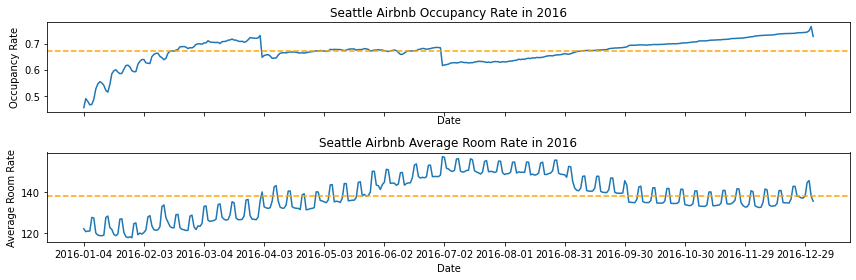

In [42]:
ticks = np.arange(0, len(occ_price_seattle.index)+1, 30)
labels = [occ_price_seattle.index[idx] for idx in ticks]

date = occ_price_seattle.index
rate_dict = [{'data': occ_price_seattle.occ_rate, 'desc': 'Occupancy Rate'},
             {'data': occ_price_seattle.avg_rate, 'desc': 'Average Room Rate'}]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12,4))

for i in [0, 1] : 
    axes[i].plot(date, rate_dict[i]['data'])
    axes[i].set_title('Seattle Airbnb ' + rate_dict[i]['desc'] + ' in 2016')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(rate_dict[i]['desc'])
    axes[i].set_xticks(labels) 
    axes[i].axhline(rate_dict[i]['data'].mean(), ls='--', color='orange', lw=1.5)
    
    fig.tight_layout()

plt.show()

In Seattle, the occupancy rate starts to increase from the beginning of 2016 until its first peak around early-April. It suddenly dips right after the April peak and stays idle until its second dip on early July. After that the trend starts to rise until the end of the year. 

When it comes to average room rate, it starts to increase from the beginning of the year until its peak near July. The room rate stays in the highest level for nearly 2 months until it slowly decreases and remains on the average level. 

<font color="orangered">Next, I will break the dates down into year, month and day for more detailed analysis.</font>

### Monthly trend for occupancy rate and average room rate in 2016
Airbnb Seattle

The below code is to break the dates into year, month and day

In [43]:
# Copy a dataframe 
monthly_analysis_seattle = calendar_sea.copy()

# Convert into datetime object : date
date_conversion = lambda x : datetime.strptime(x, "%Y-%m-%d")
monthly_analysis_seattle.date = monthly_analysis_seattle .date.apply(date_conversion)

# Insert year, month, day series into calendar dataframe
monthly_analysis_seattle.insert(2, 'year', monthly_analysis_seattle.date.apply(lambda x : x.year))
monthly_analysis_seattle.insert(3, 'month', monthly_analysis_seattle.date.apply(lambda x : x.month))
monthly_analysis_seattle.insert(4, 'day', monthly_analysis_seattle.date.apply(lambda x : x.day))

<font color='#d9534f'>The above codes take too much time, which will be improved for any later use with `break_date` function</font>

In [44]:
# Create a table that aggreates monthly average
monthly_analysis_seattle = monthly_analysis_seattle.groupby('month').mean()[['available', 'price']]
monthly_analysis_seattle.head()

,available,price
month,,
1,0.566937,122.912176
2,0.662208,124.293927
3,0.709187,128.644488
4,0.663847,135.097005
5,0.675670,139.538183


In [45]:
# Mapping integers to month name
monthly_analysis_seattle.index = map_calendar_month(monthly_analysis_seattle.index)

# Change column names
monthly_analysis_seattle.columns = ['occ_rate', 'room_rate']

# Confirm the change
monthly_analysis_seattle.head()

,occ_rate,room_rate
month,,
Jan,0.566937,122.912176
Feb,0.662208,124.293927
Mar,0.709187,128.644488
Apr,0.663847,135.097005
May,0.675670,139.538183


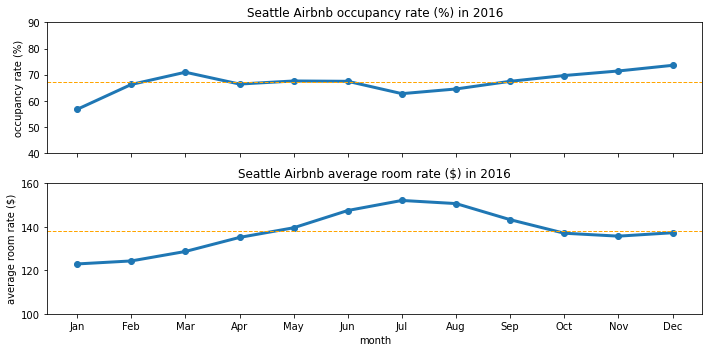

In [46]:
date = monthly_analysis_seattle.index
rate_dict = [{'data': monthly_analysis_seattle.occ_rate, 'desc': 'occupancy rate (%)'},
             {'data': monthly_analysis_seattle.room_rate, 'desc': 'average room rate ($)'}]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 5))

for i in [0, 1] : 
    axes[i].plot(date, rate_dict[i]['data'], marker='o', lw=3)
    axes[i].set_title('Seattle Airbnb ' + rate_dict[i]['desc'] + ' in 2016')
    axes[i].set_ylabel(rate_dict[i]['desc'])
    axes[i].axhline(rate_dict[i]['data'].mean(), ls='--', color='orange', lw=1)


axes[1].set_xlabel('month')    
fig.tight_layout()

axes[0].set_yticks(np.arange(0.4, 0.8 + 0.2, 0.1))
axes[0].set_yticklabels([str(occ) for occ in range(40, 80 + 20, 10)])

axes[1].set_yticks(np.arange(100, 160 + 20, 20))
axes[1].set_yticklabels([str(price) for price in range(100, 160 + 20, 20)])

plt.show()

The occupancy rate starts with the lowest level below 60% in the beginning of the year, and follows the increasing trend until March. As seen previously, there was a sudden dip April, which took effect in the occupancy rate in that month. The occupancy rate in July stays below the year's average level and it continues on in August. However, it gets recovered until its peak in December. 

Average room rates peak up in the summer period from Jun to August, whilst the higher price level may explain the lower occupancy level during the same period. However, is it good or bad? It is hard to see the performance by seperating the occupany rate and average room rate, and there is a metric that the hotel industry uses to measure the business performance, called RevPar.

 ### How about RevPar ? 

RevPAR, or revenue per available room, is a performance metric in the hotel industry that is calculated by dividing a hotel's total guestroom revenue by the room count and the number of days in the period being measured. https://en.wikipedia.org/wiki/RevPAR

It can alternatively be calculated as $occupancy rate (# room occupied / # available) x average room rate$.

In [47]:
monthly_analysis_seattle['revpar'] = ( monthly_analysis_seattle.occ_rate 
                                      * monthly_analysis_seattle.room_rate )

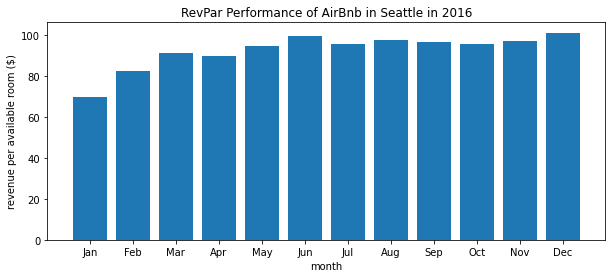

<Figure size 432x288 with 0 Axes>

In [48]:
date = monthly_analysis_seattle.index
revpar = monthly_analysis_seattle['revpar']
layout_obj = {
    'title': 'RevPar Performance of AirBnb in Seattle in 2016',
    'xlabel': 'month',
    'ylabel': 'revenue per available room ($)'
}

plot_bar_chart(date, revpar, layout_obj, rotation=False)

plt.savefig('assets/revparSeattle.png', format='png')
plt.show()

In [49]:
monthly_analysis_seattle['revpar'].sort_values(ascending=False)

month
Dec    100.958803
Jun     99.453597
Aug     97.181255
Nov     96.879911
Sep     96.612092
Oct     95.444659
Jul     95.377854
May     94.281823
Mar     91.233047
Apr     89.683700
Feb     82.308439
Jan     69.683499
Name: revpar, dtype: float64

The RevPar is \\$99.45 in June, which is the second highest level through the year. It looks that the decrease in occupancy rate in August affected the RevPar but the performance in August is not too bad with \\$97.18. 

RevPar performance is quite steady from Q3 onwards, but a further study seems necessary to figure out why it started low in the beginning of the year. Supposedly there was a series of concerns around Airbnb that may have affected the confidence from consumer and hosts, as following:

- Concerns over the company's affecting the local housing market affordability and some political consideration were expected whether to regulate the company's activity: [source1](https://www.seattletimes.com/business/airbnb-says-its-rentals-arent-affecting-housing-affordability/) [source2](https://www.geekwire.com/2016/seattle-regulates-airbnb-company-releases-study-showing-178m-annual-impact-local-economy/)

- Airbnb will start collecting taxes in Washington state: [source](https://www.geekwire.com/2015/airbnb-will-start-collecting-taxes-in-washington-state-on-behalf-of-hosts)

---
## Extend the analysis to Boston data
Use functions (DRY principle) to perform the above CRISP-DM process 

### Data exploration
The date period is not consistent across Seattle and Boston dataset!

In [50]:
calendar_bos.date.sort_values() # Boston calendar data starts from 2016-09-06

654444     2016-09-06
440919     2016-09-06
440554     2016-09-06
440189     2016-09-06
439824     2016-09-06
              ...    
1218735    2017-09-05
425513     2017-09-05
734628     2017-09-05
1048645    2017-09-05
0          2017-09-05
Name: date, Length: 1308890, dtype: object

In [51]:
calendar_sea.date.sort_values()

0          2016-01-04
1171285    2016-01-04
442380     2016-01-04
997180     2016-01-04
1203040    2016-01-04
              ...    
924544     2017-01-02
924179     2017-01-02
923814     2017-01-02
928194     2017-01-02
1393569    2017-01-02
Name: date, Length: 1393570, dtype: object

There is an issue in date consistency between Seattle and Boston calendar data. Boston calendar data has a date range from 2016-09-06 to 2017-09-05, whereas Seattle data is for the period between 2016-01-04 and 2017-01-02.

<font color="orangered">Therefore it is not a good idea to compare the two cities' performances by monthly.</font>

---
## Comparison between Seattle and Boston
The transformed data shows daily average.

Terminology used: 
- Occupancy rate : # rooms rented out / # total available rooms on a given day
- Average room rate : average price of available rooms on a given day
- Revpar : Occupancy rate x Average room rate, which is an aggregated meature to evaluate rental performance

### Create a new data table for comparative analysis

In [52]:
def get_analysis_table(df) : 
    ''' Create a new table customized for Airbnb performance analysis
    
    INPUT  : calendar dataframe
    OUTPUT : a new dataframe with data (daily) as index and 
    three key performance metrics as features - occupancy rate, average room rate and revpar
    '''

    table = df.groupby('date').mean().drop(columns='listing_id')
    table.columns = ['occ_rate', 'avg_room_rate'] # daily

    table['revpar'] = table['occ_rate'] * table['avg_room_rate']

    return table

In [54]:
analysis_seattle = get_analysis_table(calendar_sea.copy())
analysis_boston = get_analysis_table(calendar_bos.copy())

### Occupancy rate

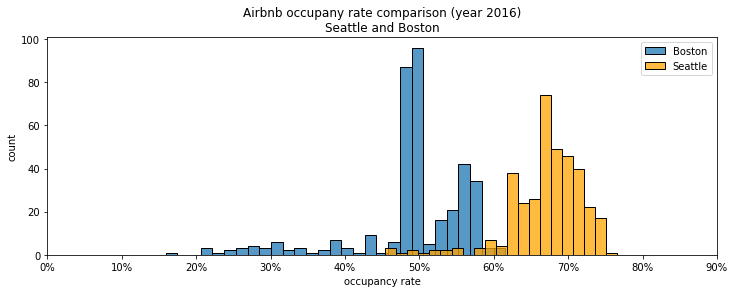

In [55]:
title = 'Airbnb occupany rate comparison (year 2016)\nSeattle and Boston'
xlabel = 'occupancy rate'
ylabel = 'count'

fig, ax = plt.subplots(figsize=(12,4))
ax = sns.histplot(analysis_boston['occ_rate'], label='Boston')
sns.histplot(analysis_seattle['occ_rate'], ax=ax, color='orange', label='Seattle');

ax.set(xlabel=xlabel, ylabel=ylabel, title=title);
ax.set_xticks(np.arange(0, 1, 0.1))
ax.set_xticklabels(f'{i}%' for i in np.arange(0, 100, 10))

plt.legend()

plt.savefig(fname='assets/occ.png', format='png')
plt.show()

### Room rate

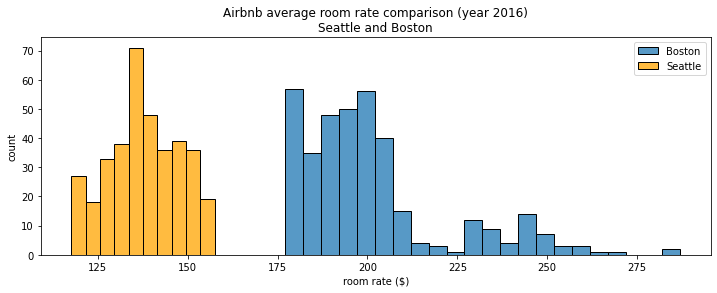

In [56]:
title = 'Airbnb average room rate comparison (year 2016)\nSeattle and Boston'
xlabel = 'room rate ($)'
ylabel = 'count'

fig, ax = plt.subplots(figsize=(12,4))
ax = sns.histplot(analysis_boston['avg_room_rate'], label='Boston')
sns.histplot(analysis_seattle['avg_room_rate'], ax=ax, color='orange', label='Seattle');

ax.set(xlabel=xlabel, ylabel=ylabel, title=title);

plt.legend()

plt.savefig('assets/adr.png', format='png')
plt.show()

### RevPar

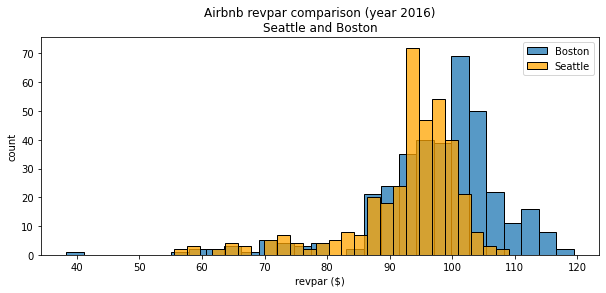

In [57]:
title = 'Airbnb revpar comparison (year 2016)\nSeattle and Boston'
xlabel = 'revpar ($)'
ylabel = 'count'

fig, ax = plt.subplots(figsize=(10,4))
ax = sns.histplot(analysis_boston['revpar'], label='Boston')
sns.histplot(analysis_seattle['revpar'], ax=ax, color='orange', label='Seattle');

ax.set(xlabel=xlabel, ylabel=ylabel, title=title);

plt.legend()

plt.savefig('assets/revpar.png', format='png')
plt.show()

In [58]:
print(f'SEATTLE:\n{analysis_seattle.describe()}')
print()
print(f'BOSTON:\n{analysis_boston.describe()}')

SEATTLE:
         occ_rate  avg_room_rate      revpar
count  365.000000     365.000000  365.000000
mean     0.670610     137.901783   92.507204
std      0.047899       9.860142    9.165813
min      0.454426     117.685413   55.479047
25%      0.647197     132.446443   90.289419
50%      0.674961     136.731206   94.582504
75%      0.702462     146.930502   97.844421
max      0.765322     157.480000  109.101886

BOSTON:
         occ_rate  avg_room_rate      revpar
count  365.000000     365.000000  365.000000
mean     0.491284     201.165200   97.489904
std      0.076196      20.989130   10.679226
min      0.158951     177.023002   38.314278
25%      0.484663     186.764936   92.868935
50%      0.493865     196.100469   99.741495
75%      0.542666     205.207474  103.198550
max      0.615449     286.921977  119.380926


Overall, revpar performance is better in Boston than in Seattle. Although occupancy rate in Seattle is more stable (by standard deviation) and higher (67%, median) on average, the difference of average room rate between the two cities is larger.

---
<a id="question2"></a>
## `QUESTION2`  How much growth potential did Airbnb have?

<br>

<font color="orangered">Earlier we saw the first quarater revpar performance in Seattle is low, due to both occupancy rate and revpar below the average level.</font> To gain a better insight, I would like to explore supply side during the same period.

Discovering the supply side, particularly in the following areas:

- \# of new hostings : `host_since`, `calculated_host_listings_count`
- number of super_host : `host_is_superhost`
- hosting type: [`property_type`, `room_type`, `price`, ...]


In [59]:
# Load cleaned dataframes
host_seattle = pd.read_csv('data/listings_seattle_cleaned.csv')
host_boston = pd.read_csv('data/listings_boston_cleaned.csv')

### Yearly growth of new listings
Aggreated to the number of unique host id by year

In [60]:
new_hosting_seattle = host_seattle.groupby('year').count()['host_id']
new_hosting_boston = host_boston.groupby('year').count()['host_id']

In [61]:
analysis_new_hostings = pd.concat([new_hosting_seattle.rename('new_hosting_seattle'), 
                                   new_hosting_boston.rename('new_hosting_boston')], axis=1)

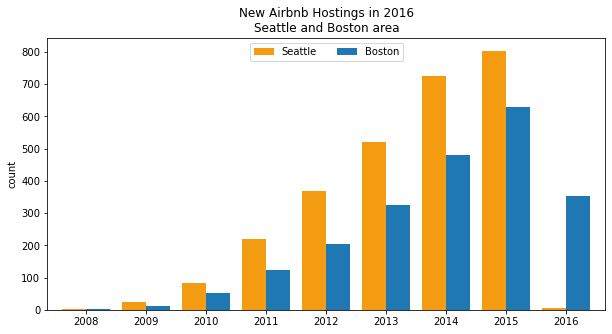

In [62]:
analysis_new_hostings.plot.bar(figsize=(10,5), width=0.8, color=['#f39c12', '#1f77b4'])

plt.title('New Airbnb Hostings in 2016\nSeattle and Boston area')
plt.xlabel('')
plt.ylabel('count')
plt.xticks(rotation=0)
plt.legend(labels=['Seattle', 'Boston'], loc='upper center', ncol=6)

plt.savefig('assets/newListings.png', format='png')
plt.show()

The joining of new hosts has been growing rapidly (can say exponentially) since the establishment of Airbnb (2008) in both Seattle and Boston markets. The number of new hostings is larger in Seattle than Boston - may possibly be due to lots of reasons i.e. more favourable regulation, demographic, market acitivities, etc. 

However, the new hostings became significantly idle in 2016 for both Seattle and Boston markets. This may be resulted from error in data collection but assuming data is super reliable, new regulatatory move and tax policy may have made potential hosts to be more cautious in renting out their properties in Seattle as considered earlier during revpar analysis (resources can be found as below).

- Concerns over the company's affecting the local housing market affordability and some political consideration were expected whether to regulate the company's activity: [source1](https://www.seattletimes.com/business/airbnb-says-its-rentals-arent-affecting-housing-affordability/) [source2](https://www.geekwire.com/2016/seattle-regulates-airbnb-company-releases-study-showing-178m-annual-impact-local-economy/)

- Airbnb will start collecting taxes in Washington state: [source](https://www.geekwire.com/2015/airbnb-will-start-collecting-taxes-in-washington-state-on-behalf-of-hosts)

## EXTRA analysis  of general hosting statistics 
To gain insights into hostings : `superhost`, `property_type`, `room_type`, `price`

### How much percentage superhost accounts for?

In [63]:
is_superhost_sea = host_seattle.host_is_superhost.value_counts()
is_superhost_bos = host_boston.host_is_superhost.value_counts()

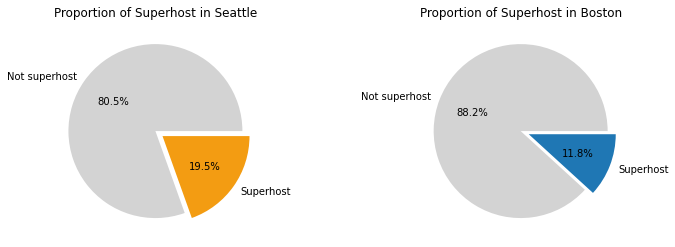

In [64]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,4))

ax1.pie(is_superhost_sea, labels=['Not superhost', 'Superhost'], autopct='%1.1f%%', explode=(0, 0.1), 
        colors=['#d3d3d3', '#f39c12'])
ax2.pie(is_superhost_bos, labels=['Not superhost', 'Superhost'], autopct='%1.1f%%', explode=(0, 0.1),
        colors=['#d3d3d3', '#1f77b4'])

ax1.set_title(f'Proportion of Superhost in Seattle')
ax2.set_title(f'Proportion of Superhost in Boston')

plt.savefig('assets/superhost.png', format='png')
plt.show()

**Terminology:**

According to Aibnb, "Superhosts are experienced hosts who provide a shining example for other hosts, and extraordinary experiences for their guests." [Reference](https://www.airbnb.com/help/article/828/what-is-a-superhost)

To retain Superhost status, hosts should satisfies the performance standards and other qualifications for the most recent 12 months from the review date. This suggests that superhosts represent dedicated property suppliers in a fairly consistent manner. Source at the link [here]((https://www.airbnb.com/superhost/terms)

**Findings:**

Nearly 20% of the total hostings are made by Superhost in Seattle as opposed to 12% in Boston. It suggests that overall rental room supply is more consistent and stable in Seattle with more dedicated property owners. On the other hand, it may also be a barrier to entry for potential hosts facing stornger competitions already existing.

Whether this affected the sudden decrease in new listings in 2016 is not so obvious, and leaves a room for a further analysis, which however will not be covered in this notebook.

### Property type

In [65]:
property_type_seattle = host_seattle.property_type.value_counts()
property_type_boston = host_boston.property_type.value_counts()

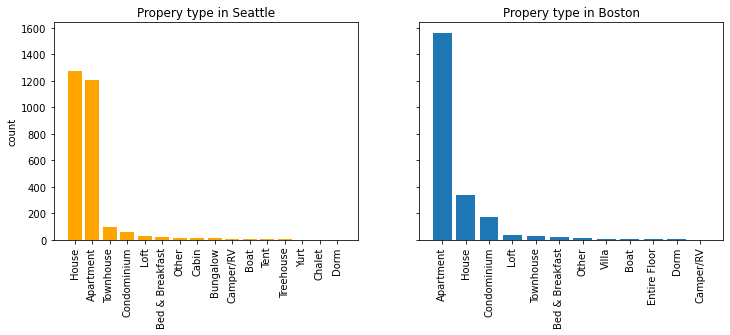

In [66]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,4))

ax1.bar(property_type_seattle.index, property_type_seattle.values, color='orange')
ax2.bar(property_type_boston.index, property_type_boston.values)

ax1.set_title(f'Propery type in Seattle')
ax2.set_title(f'Propery type in Boston')
ax1.set_ylabel('count')

# Two different ways to set xticks in subplot
ax1.set_xticks(property_type_seattle.index)
ax1.set_xticklabels(property_type_seattle.index, rotation=90)
    
for tick in ax2.get_xticklabels() :
    tick.set_rotation(90) 

In 2016, House (46%) and Apartment (44%) were the most common types of properties in Seattle, whereas large proportion of hosts (nearly 72% of total) offered Apartment in Boston.

### Room type

In [67]:
room_type_seattle = host_seattle.room_type.value_counts()
room_type_boston = host_boston.room_type.value_counts()

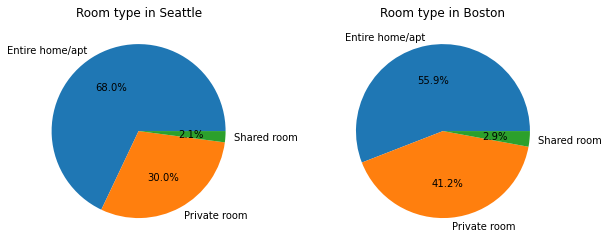

In [68]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,4))

ax1.pie(room_type_seattle.values, labels=room_type_seattle.index, autopct='%1.1f%%')
ax2.pie(room_type_boston.values, labels=room_type_boston.index, autopct='%1.1f%%')

ax1.set_title(f'Room type in Seattle')
ax2.set_title(f'Room type in Boston')

plt.show()

Hosts tended to rent out entire home/apartment as opposed to than shared / private room only in both Seattle and Boston.

### Room Price

In [69]:
# Convert price into numercial variable
host_seattle.price = convert_price_float(host_seattle.price)
host_boston.price = convert_price_float(host_boston.price)

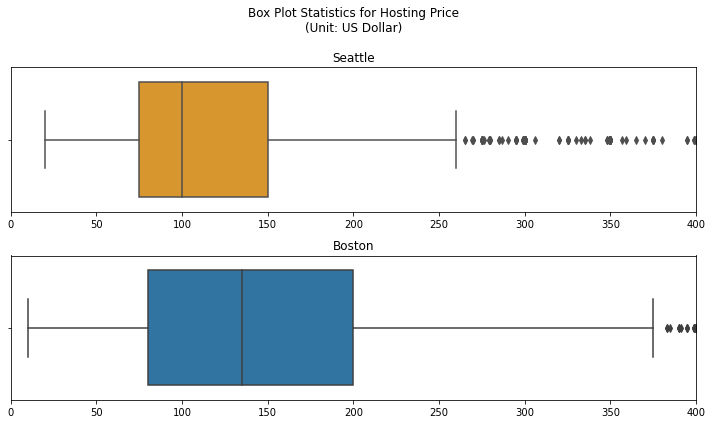

In [70]:
plt.figure(figsize=(10,6))

plt.subplot(2,1,1)
sns.boxplot(x=host_seattle.price, color='#f39c12')
plt.title('Box Plot Statistics for Hosting Price\n(Unit: US Dollar)\n\nSeattle')
plt.xlabel('')
plt.xlim((0,400))

      
plt.subplot(2,1,2)
sns.boxplot(x=host_boston.price)
plt.title('Boston')
plt.xlabel('')
plt.xlim((0,400))

plt.tight_layout()

plt.savefig('assets/priceStats.png', format='png')
plt.show()

Room price range is wider in Boston than Seattle. The median room price is also higher in Boston.

---
<a id="question3"></a>
## `QUESTION3`  Which neighborhood has more expensive listings?

### Leaving features that are only relevant to the analysis

In [71]:
cols_neighbor = [
    'id', 'neighborhood_overview', 'street', 'neighbourhood', 'neighbourhood_cleansed', 
    'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 
    'smart_location', 'country_code', 'country', 'latitude', 'longitude',
    'is_location_exact', 'property_type', 'room_type', 'accommodates',
    'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 
    'availability_30', 'availability_60', 'availability_90', 
    'availability_365'
]

In [72]:
neighbor_seattle_temp = listings_seattle[cols_neighbor].copy()
neighbor_boston_temp = listings_boston[cols_neighbor].copy()

In [73]:
neighbor_seattle_temp.columns

Index(['id', 'neighborhood_overview', 'street', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city',
       'state', 'zipcode', 'market', 'smart_location', 'country_code',
       'country', 'latitude', 'longitude', 'is_location_exact',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities', 'square_feet', 'price',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365'],
      dtype='object')

### Additional data cleaning

In [74]:
def wrangle_airbnb_neighbor_data(df) :
    '''
    Remove duplicates and convert to datatype relevant for the analysis
    
    INPUT  : Airbnb 'listings' dataframe trimmed for neighborhood analysis
    OUTPUT : A new, cleaned dataframe ready for the analysis
    
    '''
    
    print(f'Original dataframe: {df.shape}')
    
    df_clean = df.copy()
    
    isDuplicated = df_clean.duplicated(subset=['id'], keep=False).sum()
    if( isDuplicated != 0 ) :
        df_clean = df_clean.drop_duplicates(subset=['id'], keep='last')
        
    df_clean.price = convert_price_float(df_clean.price)
    
    print(f'Cleaned dataframe: {df.shape}')
    
    return df_clean

In [75]:
neighbor_seattle = wrangle_airbnb_neighbor_data(neighbor_seattle_temp)
neighbor_boston = wrangle_airbnb_neighbor_data(neighbor_boston_temp)

Original dataframe: (3818, 30)
Cleaned dataframe: (3818, 30)
Original dataframe: (3585, 30)
Cleaned dataframe: (3585, 30)


### GeoPandas mapping
`geodata` folder contains shape files for Seattle and Boston

Reference: [GeoPandas 101: Plot any data with a latitude and longitude on a map](https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972)
  
Data source: 
- [City of Seattle](https://data-seattlecitygis.opendata.arcgis.com/datasets/city-clerk-neighborhoods)
- [Boston GIS](https://bostonopendata-boston.opendata.arcgis.com/datasets/3525b0ee6e6b427f9aab5d0a1d0a1a28_0)

In [76]:
# Load shape files
seattle_map = gpd.read_file('geodata/seattle/City_Clerk_Neighborhoods.shp')
boston_map = gpd.read_file('geodata/boston/Boston_Neighborhoods.shp')

In [77]:
# Create a list of geometry points with longitude, latitude data
geometry_seattle = create_points_geometry(neighbor_seattle['longitude'], neighbor_seattle['latitude'])
geometry_boston = create_points_geometry(neighbor_boston['longitude'], neighbor_boston['latitude'])

In [78]:
# Create GeoDataFrame and set coordinates reference system (crs)
gdf_seattle = gpd.GeoDataFrame(neighbor_seattle, geometry = geometry_seattle)
gdf_boston = gpd.GeoDataFrame(neighbor_boston, geometry = geometry_boston)

In [79]:
# Additional feature 'geometry' added onto the original dataframes 
gdf_seattle.geometry[:2], gdf_boston.geometry[:2]

(0    POINT (-122.37103 47.63629)
 1    POINT (-122.36567 47.63912)
 Name: geometry, dtype: geometry,
 0    POINT (-71.13307 42.28262)
 1    POINT (-71.13437 42.28624)
 Name: geometry, dtype: geometry)

### Visualization and analysis

Creating 4 price categories for visualization based on 5 number statistics (quartiles) 

Terminology :
- $\text{\$\$\$\$}$  :  Top 25%
- $\text{\$\$\$}$ :  Top 25% - 50%
- $\text{\$\$}$ :  Bottom 25% - 50%
- $\text{\$}$ :  Bottom 25%

In [80]:
seattle_price_bins = gdf_seattle.price.describe()[3:]
seattle_price_group = pd.cut(x=gdf_seattle.price, bins=seattle_price_bins.values, 
                             labels=['\$', '\$\$', '\$\$\$', '\$\$\$\$'])

gdf_seattle['price_group'] = seattle_price_group

In [81]:
# To create texts index for top priced neighorhoods 
neighbor_sea = gdf_seattle.groupby('neighbourhood_cleansed').mean()
lat_lng_sea = neighbor_sea[['latitude', 'longitude', 'price']].sort_values(by='price', ascending=False)

In [82]:
price_summary_sea = lat_lng_sea.price.describe()[3:]
price_summary_sea

min     68.555556
25%     95.950928
50%    121.800000
75%    142.704082
max    231.705882
Name: price, dtype: float64

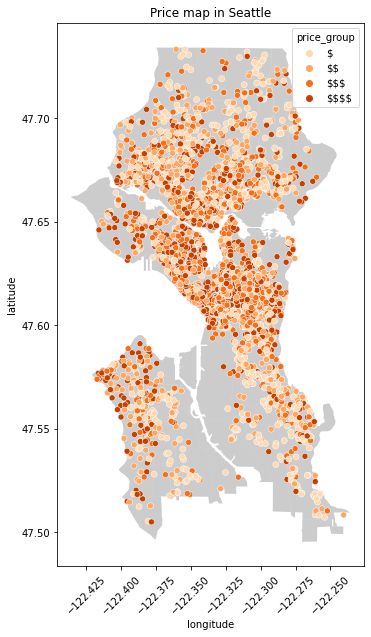

In [83]:
seattle_map.plot(alpha=0.4, color='grey', figsize=(10, 10))
sns.scatterplot(data=gdf_seattle, x='longitude', y='latitude', hue='price_group', 
                palette='Oranges')

plt.title('Price map in Seattle')
plt.xticks(rotation=45)

plt.savefig('assets/seattlePriceMap.png', format='png')
plt.show()

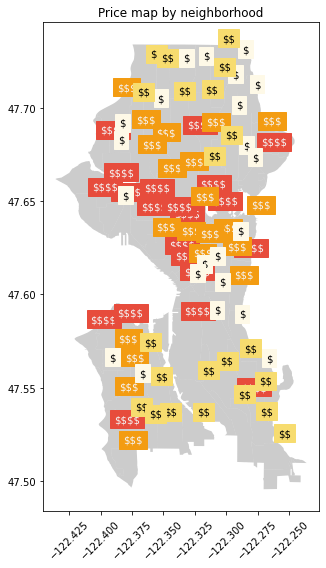

In [84]:
# Simplified plot
seattle_map.plot(alpha=0.4, color='grey', figsize=(9, 9))
plt.title('Price map by neighborhood')

for i, values in enumerate(lat_lng_sea.itertuples()) :
    area, lat, lng, price = values

    if price > price_summary_sea[3]: 
        plt.text(x=lng, y=lat+0.01, s='\$\$\$\$', 
                 backgroundcolor='#E74C3C', color='#f3f3f3')

    elif price > price_summary_sea[2] : 
        plt.text(x=lng, y=lat+0.01, s='\$\$\$', backgroundcolor='#F39C12', color='#f3f3f3')
    
    elif price < price_summary_sea[1] : 
        plt.text(x=lng, y=lat+0.01, s='\$\$', backgroundcolor='#F7DC6F')
        
    else:
        plt.text(x=lng, y=lat+0.01, s='\$', backgroundcolor='#FEF9E7')
        
        
plt.xticks(rotation=45)
plt.show()

Rental price is generally higher around the central bay area, and gets cheaper as properities get away from the centeral Seattle.

In [85]:
round(neighbor_sea['price'].nlargest(10), 2)

neighbourhood_cleansed
Southeast Magnolia     231.71
Portage Bay            227.86
Westlake               194.47
West Queen Anne        187.77
Montlake               182.79
Briarcliff             176.57
Sunset Hill            176.06
Industrial District    173.33
Alki                   171.62
Windermere             169.90
Name: price, dtype: float64

### Plotting Boston price distribution

In [86]:
boston_price_bins = gdf_boston.price.describe()[3:]

boston_price_group = pd.cut(x=gdf_boston.price, bins=boston_price_bins.values, 
                             labels=['\$', '\$\$', '\$\$\$', '\$\$\$\$'])

gdf_boston['price_group'] = boston_price_group

In [87]:
# To create texts index for top priced neighorhoods 
neighbor_bos = gdf_boston.groupby('neighbourhood_cleansed').mean()
lat_lng_bos = neighbor_bos[['latitude', 'longitude', 'price']].sort_values(by='price', ascending=False)
price_summary_bos = lat_lng_bos.price.describe()[3:]

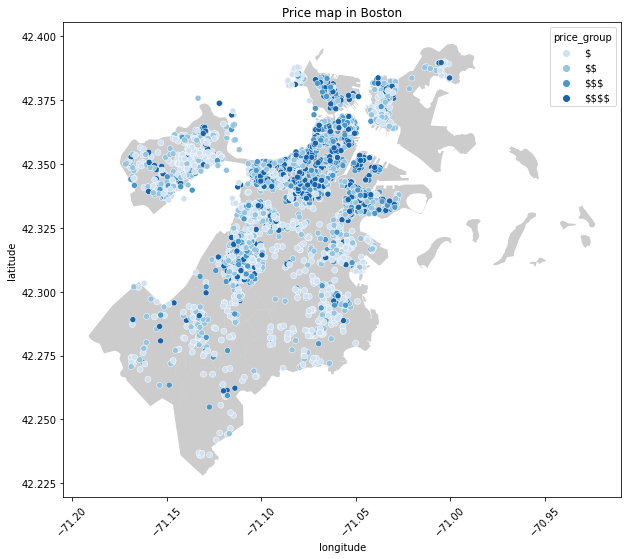

In [88]:
boston_map.plot(alpha=0.4, color='grey', figsize=(10,10))
sns.scatterplot(data=gdf_boston, x='longitude', y='latitude', hue='price_group', 
                palette='Blues')

plt.title('Price map in Boston')
plt.xticks(rotation=45)

# plt.savefig('assets/bostonPriceMap.png', format='png')
plt.show()

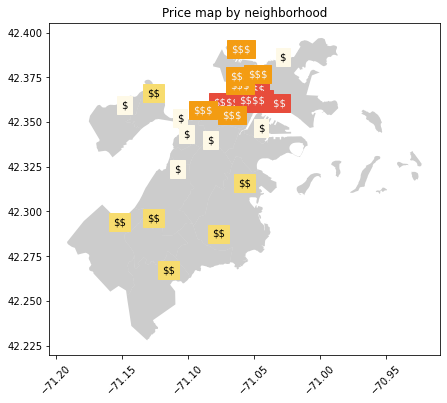

In [89]:
# Simplified plot
boston_map.plot(alpha=0.4, color='grey', figsize=(7, 7))
plt.title('Price map by neighborhood')

for i, values in enumerate(lat_lng_bos.itertuples()) :
    area, lat, lng, price = values

    if price > price_summary_bos[3]: 
        plt.text(x=lng, y=lat+0.01, s='\$\$\$\$', 
                 backgroundcolor='#E74C3C', color='#f3f3f3')

    elif price > price_summary_bos[2] : 
        plt.text(x=lng, y=lat+0.01, s='\$\$\$', backgroundcolor='#F39C12', color='#f3f3f3')
    
    elif price < price_summary_bos[1] : 
        plt.text(x=lng, y=lat+0.01, s='\$\$', backgroundcolor='#F7DC6F')
        
    else:
        plt.text(x=lng, y=lat+0.01, s='\$', backgroundcolor='#FEF9E7')
        
        
plt.xticks(rotation=45)
plt.show()

Just like Seattle, the listings in the downtown area are generally the most expensive in Boston, and the price gets lower as the location of properties is away from the center.

In [90]:
round(neighbor_bos['price'].nlargest(10), 2)

neighbourhood_cleansed
South Boston Waterfront    306.06
Bay Village                266.83
Leather District           253.60
Back Bay                   240.95
Downtown                   236.46
Chinatown                  232.35
Beacon Hill                224.44
Fenway                     220.39
West End                   209.59
South End                  204.35
Name: price, dtype: float64

---
<a id="bottom"></a>
[Go back to the top](#top)